[View in Colaboratory](https://colab.research.google.com/github/opooladz/ESPRIT-Autoencoder-Anomaly-Detection/blob/master/Copy_of_ESPRIT2.ipynb)

In [0]:
!apt-get install nvidia-cuda-toolkit
!pip3 install numba

import os
os.environ['NUMBAPRO_LIBDEVICE'] = "/usr/lib/nvidia-cuda-toolkit/libdevice"
os.environ['NUMBAPRO_NVVM'] = "/usr/lib/x86_64-linux-gnu/libnvvm.so"

from numba import cuda
import numpy as np
import time

@cuda.jit
def hello(data):
    data[cuda.blockIdx.x, cuda.threadIdx.x] = cuda.blockIdx.x

numBlocks = 5
threadsPerBlock = 10

data = np.ones((numBlocks, threadsPerBlock), dtype=np.uint8)

hello[numBlocks, threadsPerBlock](data)

print(data)

In [0]:
!pip install numba

    100% |████████████████████████████████| 1.9MB 7.9MB/s 
    100% |████████████████████████████████| 15.9MB 2.5MB/s 


In [1]:
import numpy as np
from scipy.linalg import toeplitz
from numpy import linalg as lg
from time import time
from typing import Tuple
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from numba import jit

flatten = lambda l: [item for sublist in l for item in sublist]

@jit
def compute_autocovariance(x: np.ndarray, M: int) -> np.ndarray:
    """
    This function compute the auto-covariance matrix of a numpy signal.
    The auto-covariance is computed as follows
    .. math:: \textbf{R}=\frac{1}{N}\sum_{M-1}^{N-1}\textbf{x}_{m}\textbf{x}_{m}^{H}
    where :math:`\textbf{x}_{m}^{T}=[x[m],x[m-1],x[m-M+1]]`.
    :param x: 1-D vector of size N
    :param M:  int, optional. Size of signal block.
    :returns: NxN ndarray
    """

    # Create covariance matrix for psd estimation
    # length of the vector x
    x = np.asarray(x).squeeze()
    assert x.ndim == 1, '1-D only'
    N = x.size

    # Create column vector (Nx1) from row array
    x_vect = x[None, :].T

    # init covariance matrix
    yn = x_vect[M-1::-1]  # reverse order from M-1 to 0

    R = yn @ yn.conj().T  # zeroth lag
    # about 5-8% of computation time
    for i in range(1, N-M):  # no zero because we just computed it
        # extract the column vector
        yn = x_vect[M-1+i:i-1:-1]

        R = R + yn @ yn.conj().T

    return R / N
@jit
def wrapper(x):
  return np.convolve(x,xc,mode="valid")

@jit
def esprit1(x: np.ndarray, L: int, M: int=None, fs: int=1,
           verbose: bool=False) -> Tuple[np.ndarray, np.ndarray]:
    """
    This function estimate the frequency components based on the ESPRIT algorithm [ROY89]_
    The frequencies are related to the roots as :math:`z=e^{-2j\pi f/Fe}`.
    See [STO97]_ section 4.7 for more information about the implementation.
    :param x: ndarray, Nsamples
    :param L: int. Number of components to be extracted.
    :param M:  int, optional. Size of signal block.
    :param Fs: float. Sampling Frequency.
    :returns: ndarray ndarray containing the L frequencies
    >>> import numpy as np
    >>> import spectral_analysis.spectral_analysis as sa
    >>> Fe=500
    >>> t=1.*np.arange(100)/Fe
    >>> x=np.exp(2j*np.pi*55.2*t)
    >>> f=sa.Esprit(x,1,None,Fe)
    >>> print(f)
    """

    x = np.asarray(x).squeeze()
    assert x.ndim in (1, 2)
    # length of the vector x
    if x.ndim == 1:
        N = x.size
    else:
        N = x.shape[1]

    if M is None:
        M = N // 2
# %% extract signal subspace  99.9 % of computation time
    tic = time()
    if x.ndim == 1 and isinstance(M, int):
        R = compute_autocovariance(x, M)  # 75% of computation time        
    else:
        # the random phase of transmit/receive/target actually helps--need at least 5-6 observations to make useful
        R = np.cov(x, rowvar=False)
    if verbose:
        print('autocov sec.', time()-tic)
    # R = subspace.corrmtx(x.astype(complex128),M).astype(float) #f2py fortran

    tic = time()
    #U, S, V = lg.svd(R)  # 25% of computation time
    w, v = lg.eig(R)    
    idx = w.argsort()[::-1]   
    w = w[idx]
    v = v[:,idx]    
    if verbose:
        print('svd sec.', time()-tic)
# %% take eigenvalues and determine sinusoid frequencies
    # Remove last row
    S1 = v[:-1, :L]
    # Remove first row
    S2 = v[1:, :L]

    # Compute matrix Phi (Stoica 4.7.12)  <0.1 % of computation time
    Phi = lg.inv(S1.conj().T @ S1) @ S1.conj().T @ S2

    # Perform eigenvalue decomposition <0.1 % of computation time
    V, U = lg.eig(Phi)

    # extract frequencies ((note that there a minus sign since Yn are defined as [y(n), y(n-1),y(n-2),..].T))
    ang = -np.angle(V)

    # frequency normalisation
    f = fs*ang / (2.*np.pi)
    t = np.arange(0, 0.01, 1/fs)
    
    x2 = np.exp(-1j*2*np.pi*t[::-1])[:,np.newaxis]**f
    #display(xc.shape)
    #ampCisoid = np.apply_along_axis(lambda q: np.convolve(q,xc,mode="valid"),axis = 0,arr=x2)
    ampCisoid = np.apply_along_axis(wrapper,axis = 0,arr=x2)
    return f, np.abs(w[:L]), np.abs(ampCisoid)*1./480., np.angle(ampCisoid)
  

def esprit2(x: np.ndarray, L: int, M: int=None, fs: int=1,
           verbose: bool=False) -> Tuple[np.ndarray, np.ndarray]:
    """
    This function estimate the frequency components based on the ESPRIT algorithm [ROY89]_
    The frequencies are related to the roots as :math:`z=e^{-2j\pi f/Fe}`.
    See [STO97]_ section 4.7 for more information about the implementation.
    :param x: ndarray, Nsamples
    :param L: int. Number of components to be extracted.
    :param M:  int, optional. Size of signal block.
    :param Fs: float. Sampling Frequency.
    :returns: ndarray ndarray containing the L frequencies
    >>> import numpy as np
    >>> import spectral_analysis.spectral_analysis as sa
    >>> Fe=500
    >>> t=1.*np.arange(100)/Fe
    >>> x=np.exp(2j*np.pi*55.2*t)
    >>> f=sa.Esprit(x,1,None,Fe)
    >>> print(f)
    """

    x = np.asarray(x).squeeze()
    assert x.ndim in (1, 2)
    # length of the vector x
    if x.ndim == 1:
        N = x.size
    else:
        N = x.shape[1]

    if M is None:
        M = N // 2
# %% extract signal subspace  99.9 % of computation time
    tic = time()
    if x.ndim == 1 and isinstance(M, int):
        R = compute_autocovariance(x, M)  # 75% of computation time
    else:
        # the random phase of transmit/receive/target actually helps--need at least 5-6 observations to make useful
        R = np.cov(x, rowvar=False)
    if verbose:
        print('autocov sec.', time()-tic)
    # R = subspace.corrmtx(x.astype(complex128),M).astype(float) #f2py fortran

    tic = time()
    U, S, V = lg.svd(R)  # 25% of computation time
    #w, v = lg.eig(R)    
    #idx = w.argsort()[::-1]   
    #w = w[idx]
    #v = v[:,idx]    
    if verbose:
        print('svd sec.', time()-tic)
# %% take eigenvalues and determine sinusoid frequencies
    # Remove last row
    S1 = U[:-1, :L]
    # Remove first row
    S2 = U[1:, :L]

    # Compute matrix Phi (Stoica 4.7.12)  <0.1 % of computation time
    Phi = lg.inv(S1.conj().T @ S1) @ S1.conj().T @ S2

    # Perform eigenvalue decomposition <0.1 % of computation time
    V, U = lg.eig(Phi)

    # extract frequencies ((note that there a minus sign since Yn are defined as [y(n), y(n-1),y(n-2),..].T))
    ang = -np.angle(V)

    # frequency normalisation
    f = fs*ang / (2.*np.pi)

    return f, S[:L]

Using TensorFlow backend.


In [228]:
from time import time
import numpy as np
from pandas import DataFrame

# Bool: Needs to be set by user 
full_anom = 0
anom_samples = 1

x = np.random.randn(4096).astype(np.complex128)
F = 12345.6

f0 = 12345.6
f1 = 1000.6
f2 = 726.6
f3 = 57.3

f0=np.random.uniform(low=0.,high = 10000.)
f1=np.random.uniform(low=0.,high = 10000.)
f2=np.random.uniform(low=0.,high = 10000.)
f3 = np.random.uniform(low=0.,high = 10000.)


c0 = 15.
c1 = 7.
c2 = 10.
c0= np.random.uniform(low=3.,high = 100.)
c1= np.random.uniform(low=3.,high = 100.)
c2= np.random.uniform(low=3.,high = 100.)
c3 = np.random.uniform(low=3.,high = 100.)

fs = 48e3
snr = 20.  # dB
Ntone = 6

t = np.arange(0, 0.01, 1/fs)

nvar = 10**(-snr/10.)



M = [100] * 300  # iterating over block length

py = DataFrame(index=M, columns=['err', 'sigma','cisoidAmp','cisoidAngle'])
fortreal = DataFrame(index=M, columns=['err', 'sigma','cisoidAmp','cisoidAngle'])
fortcmpl = DataFrame(index=M, columns=['err', 'sigma','cisoidAmp','cisoidAngle'])
fest = []
fest2 = []
cisoidAmp = []
cisoidAmp2 = []
i = 0
for m in M:
    i = i + 1
    # Generate fist tripplet of cisoid  
    # Train data start
    xc = c0*np.exp(1j*2*np.pi*f0*t)+c1*np.exp(1j*2*np.pi*f1*t) +c2*np.exp(1j*2*np.pi*f2*t)
    xc1 = xc + np.sqrt(nvar)*(np.random.randn(t.size) + 1j*np.random.randn(t.size))
  
    tmpFest, sigma,tmpAmp,cisoidAngle = esprit1(xc1, Ntone//2, M=m, fs=fs, verbose=False)
    fest.append(tmpFest)
    tmpAmp = tmpAmp[0]
    cisoidAmp.append(tmpAmp)
    # Train data end 
    
    # Test section start
    
    # Inject Anomaly
    if not(full_anom or i%40):
      display(i)
      for j in np.arange(anom_samples):
        display(i)
        xc2 = c0*np.exp(1j*2*np.pi*f0*t)+c1*np.exp(1j*2*np.pi*f1*t) +c3*np.exp(1j*2*np.pi*f3*t)+ np.sqrt(nvar)*(np.random.randn(t.size) + 1j*np.random.randn(t.size))
        tmpFest, sigma,tmpAmp,cisoidAngle = esprit1(xc2, Ntone//2, M=m, fs=fs, verbose=False)
        fest2.append(tmpFest)
        tmpAmp = tmpAmp[0]
        cisoidAmp2.append(tmpAmp) 
    # When not Anomaly use xc as baseline signal and add AWGN - Run through esprit
    xc2 = xc +  np.sqrt(nvar)*(np.random.randn(t.size) + 1j*np.random.randn(t.size))
    if full_anom:
      xc2 = c0*np.exp(1j*2*np.pi*f0*t)+c1*np.exp(1j*2*np.pi*f1*t) +c3*np.exp(1j*2*np.pi*f3*t)+ np.sqrt(nvar)*(np.random.randn(t.size) + 1j*np.random.randn(t.size))
    tmpFest, sigma,tmpAmp,cisoidAngle = esprit1(xc2, Ntone//2, M=m, fs=fs, verbose=False)
    fest2.append(tmpFest)
    tmpAmp = tmpAmp[0]
    cisoidAmp2.append(tmpAmp)  
    # Test section end 

# Create train and test set     
x_train = np.hstack((cisoidAmp,fest))    
x_test = np.hstack((cisoidAmp2,fest2))
    

40

40

80

80

120

120

160

160

200

200

240

240

280

280

In [149]:
x_train.shape

(200, 6)

In [138]:
full_anom = 0
anom_samples = 1
fest2 = []
cisoidAmp2 = []
i = 0
for m in M:
    i = i + 1
    
    # Test section start
    
    # Inject Anomaly
    if not(full_anom or i%20):
      display(i)
      for j in np.arange(anom_samples):
        display(i)
        xc2 = c0*np.exp(1j*2*np.pi*f0*t)+c1*np.exp(1j*2*np.pi*f1*t) +c2*np.exp(1j*2*np.pi*f3*t)+ np.sqrt(nvar)*(np.random.randn(t.size) + 1j*np.random.randn(t.size))
        tmpFest, sigma,tmpAmp,cisoidAngle = esprit1(xc2, Ntone//2, M=m, fs=fs, verbose=False)
        fest2.append(tmpFest)
        tmpAmp = tmpAmp[0]
        cisoidAmp2.append(tmpAmp) 
    # When not Anomaly use xc as baseline signal and add AWGN - Run through esprit
    xc2 = xc +  np.sqrt(nvar)*(np.random.randn(t.size) + 1j*np.random.randn(t.size))
    if full_anom:
      xc2 = c0*np.exp(1j*2*np.pi*f0*t)+c1*np.exp(1j*2*np.pi*f1*t) +c2*np.exp(1j*2*np.pi*f3*t)+ np.sqrt(nvar)*(np.random.randn(t.size) + 1j*np.random.randn(t.size))
    tmpFest, sigma,tmpAmp,cisoidAngle = esprit1(xc2, Ntone//2, M=m, fs=fs, verbose=False)
    fest2.append(tmpFest)
    tmpAmp = tmpAmp[0]
    cisoidAmp2.append(tmpAmp)  
    # Test section end 

# Create train and test set     
x_test = np.hstack((cisoidAmp2,fest2))

20

20

40

40

60

60

80

80

100

100

120

120

140

140

160

160

180

180

200

200

In [150]:
display(cisoidAmp2)
display(cisoidAmp)



[array([93.00542398, 68.47235078,  9.18655282]),
 array([93.00543023, 68.47235094,  9.18527796]),
 array([93.00545337, 68.47235109,  9.18466791]),
 array([93.00544724, 68.47235073,  9.18694677]),
 array([93.00544428, 68.47235109,  9.18504655]),
 array([93.00542367, 68.47235106,  9.18476745]),
 array([93.00544329, 68.47235048,  9.18740015]),
 array([93.00545165, 68.47235099,  9.18517441]),
 array([93.00542956, 68.47235104,  9.1876641 ]),
 array([93.00545083, 68.47235108,  9.18556481]),
 array([93.00543306, 68.47235103,  9.18655683]),
 array([93.0054376 , 68.47235109,  9.18438757]),
 array([93.00543856, 68.47235107,  9.18627001]),
 array([93.00543117, 68.47235094,  9.18627307]),
 array([93.00542879, 68.47235068,  9.18682128]),
 array([93.00544571, 68.47235108,  9.1871391 ]),
 array([93.00542213, 68.47235097,  9.18695734]),
 array([93.0054344 , 68.47235083,  9.18656433]),
 array([93.00542734, 68.47235097,  9.18853224]),
 array([93.00543287,  0.71454789,  9.18535378]),
 array([93.00542979,

[array([93.00544826, 68.47235071,  9.18382735]),
 array([93.00544046, 68.47235107,  9.1852524 ]),
 array([93.00542699, 68.47235071,  9.18516183]),
 array([93.00543024, 68.47235027,  9.18525339]),
 array([93.00542015, 68.47235096,  9.18518695]),
 array([93.00544385, 68.47235108,  9.18429215]),
 array([93.00544764, 68.4723507 ,  9.18658561]),
 array([93.00542074, 68.47235077,  9.1885925 ]),
 array([93.00542092, 68.47235108,  9.18651842]),
 array([93.00544275, 68.47235083,  9.18374881]),
 array([93.00543151, 68.47235098,  9.18749926]),
 array([93.00545047, 68.47235089,  9.18494787]),
 array([93.00543821, 68.47235087,  9.18587203]),
 array([93.00544978, 68.47235094,  9.18580337]),
 array([93.00545341, 68.47235103,  9.1858805 ]),
 array([93.00544423, 68.47235045,  9.18540527]),
 array([93.00544968, 68.47235106,  9.18846549]),
 array([93.0054327 , 68.47235109,  9.18698757]),
 array([93.0054339 , 68.47235098,  9.18554322]),
 array([93.00543667, 68.47235106,  9.18846946]),
 array([93.00543408,

In [116]:
display(fest2)
display(fest)



[array([2520.24601186, 6518.75541612, 5539.51346662]),
 array([2520.24082735, 6518.75611803, 5539.48113757]),
 array([2520.24404723, 6518.76260246, 5539.4891568 ]),
 array([2520.24776107, 6518.75218071, 5539.51915847]),
 array([2520.24187595, 6518.75417206, 5539.50322696]),
 array([2520.24262793, 6518.75941024, 5539.5336541 ]),
 array([2520.2371879 , 6518.75880462, 5539.48806348]),
 array([2520.24333602, 6518.75399104, 5539.55758521]),
 array([2520.24603343, 6518.75308744, 5539.50149856]),
 array([2520.24636987, 6518.7621706 , 5539.56075229]),
 array([2520.24179651, 6518.7579379 , 5539.42204218]),
 array([2520.25104699, 6518.75558791, 5539.49075416]),
 array([2520.24387559, 6518.75885616, 5539.50815474]),
 array([2520.24293999, 6518.7570123 , 5539.55807999]),
 array([2520.24548104, 6518.75312361, 5539.5309619 ]),
 array([2520.24812994, 6518.75516011, 5539.50841978]),
 array([2520.24610148, 6518.75977128, 5539.56489617]),
 array([2520.24617791, 6518.75742377, 5539.52893209]),
 array([25

[array([9845.70281756, 6518.75732165, 5539.50301356]),
 array([9845.69144295, 6518.75507602, 5539.43380359]),
 array([9845.6989237 , 6518.75576413, 5539.55252133]),
 array([9845.70088568, 6518.7522811 , 5539.52781744]),
 array([9845.70578037, 6518.75562625, 5539.44009269]),
 array([9845.70297198, 6518.75587981, 5539.49594468]),
 array([9845.70045592, 6518.75333391, 5539.4929031 ]),
 array([9845.69209239, 6518.75911709, 5539.53820247]),
 array([9845.70049923, 6518.75963723, 5539.53495941]),
 array([9845.69813442, 6518.75071615, 5539.51981172]),
 array([9845.69672108, 6518.75325087, 5539.45620974]),
 array([9845.69986759, 6518.75957905, 5539.53631913]),
 array([9845.69538331, 6518.75358893, 5539.56192167]),
 array([9845.69696635, 6518.75960941, 5539.50665045]),
 array([9845.70169909, 6518.7638564 , 5539.53438418]),
 array([9845.70387831, 6518.75638105, 5539.54426849]),
 array([9845.69928589, 6518.75315094, 5539.52835173]),
 array([9845.69895024, 6518.75353206, 5539.51141595]),
 array([98

In [42]:
from keras import regularizers
from sklearn.preprocessing import StandardScaler
# Make sure to run this after each new generation of data
# zero mean and unit var
x_train2 = StandardScaler().fit_transform(x_train)
x_test2 = StandardScaler().fit_transform(x_test)
#x_train2 = x_train2[:,:,np.newaxis]
#x_test2 = x_test2[:,:,np.newaxis]

#x_train2 = x_train2.astype('float32') / 255.
#x_test2 = x_test2.astype('float32') / 255.

display(x_train2.shape)

input_dim = x_train.shape[1]

# set size of autoencoder 
encoding_dim = 6

# use elu because it is leaky tried both net and l1 and l2 : net and l1 worked the best 
input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="elu",kernel_initializer= 'he_normal', activity_regularizer=regularizers.l1_l2(l1=10e-5, l2=10e-4))(input_layer)
#encoder = Dense(encoding_dim, activation="elu",activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="elu",kernel_initializer= 'he_normal')(encoder)
decoder = Dense(int(encoding_dim / 2), activation='elu',kernel_initializer= 'he_normal')(encoder)
decoder = Dense(input_dim, activation='elu',kernel_initializer= 'he_normal')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

autoencoder.summary()  


(200, 6)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 6)                 0         
_________________________________________________________________
dense_25 (Dense)             (None, 6)                 42        
_________________________________________________________________
dense_26 (Dense)             (None, 3)                 21        
_________________________________________________________________
dense_27 (Dense)             (None, 3)                 12        
_________________________________________________________________
dense_28 (Dense)             (None, 6)                 24        
Total params: 99
Trainable params: 99
Non-trainable params: 0
_________________________________________________________________


In [5]:
#Results with no anomily 
# Loss and Val Loss are very close + Accuracy and Val Accuracy are very close 
# Depending on the params of the net it can hit Accuracy of  1
nb_epoch = 800 # a bit overkill but wanted to see how it progressed w more epochs 
full_anom = 0
anom_samples = 0
batch_size = 32
import keras
autoencoder.compile(optimizer='nadam', 
                    loss='mean_squared_error', 
                    #loss='kullback_leibler_divergence',
                    #loss = 'binary_crossentropy',
                    metrics=['accuracy'])
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy_with_masking', factor=0.2,
                              patience=5,verbose = 1)
history = autoencoder.fit(x_train2, x_train2,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    #validation_data=(x_test2[0:200,:], x_test2[0:200,:]),
                    validation_split=.1,
                    verbose=1,callbacks=[reduce_lr])
score = autoencoder.evaluate(x_test2, x_test2, batch_size=32, verbose=1, sample_weight=None, steps=None)
display('[test_loss, test_acc]')
display(score)

Train on 180 samples, validate on 20 samples
Epoch 1/800
180/180 [==============================] - 0s 2ms/step - loss: 0.5229 - acc: 0.6167 - val_loss: 0.6079 - val_acc: 0.7500
Epoch 2/800
180/180 [==============================] - 0s 278us/step - loss: 0.5127 - acc: 0.6278 - val_loss: 0.5990 - val_acc: 0.7500
Epoch 3/800
180/180 [==============================] - 0s 307us/step - loss: 0.5022 - acc: 0.6333 - val_loss: 0.5901 - val_acc: 0.7500
Epoch 4/800
180/180 [==============================] - 0s 290us/step - loss: 0.4927 - acc: 0.6333 - val_loss: 0.5807 - val_acc: 0.7000
Epoch 5/800
 32/180 [====>.........................] - ETA: 0s - loss: 0.4667 - acc: 0.7500

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:972: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_accuracy_with_masking` which is not available. Available metrics are: val_loss,val_acc,loss,acc,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


180/180 [==============================] - 0s 320us/step - loss: 0.4829 - acc: 0.6389 - val_loss: 0.5705 - val_acc: 0.7000
Epoch 6/800
180/180 [==============================] - 0s 299us/step - loss: 0.4734 - acc: 0.6333 - val_loss: 0.5620 - val_acc: 0.6500
Epoch 7/800
180/180 [==============================] - 0s 326us/step - loss: 0.4632 - acc: 0.6556 - val_loss: 0.5519 - val_acc: 0.6500
Epoch 8/800
180/180 [==============================] - 0s 373us/step - loss: 0.4528 - acc: 0.6611 - val_loss: 0.5431 - val_acc: 0.6500
Epoch 9/800
180/180 [==============================] - 0s 320us/step - loss: 0.4432 - acc: 0.6667 - val_loss: 0.5324 - val_acc: 0.6500
Epoch 10/800
180/180 [==============================] - 0s 312us/step - loss: 0.4334 - acc: 0.6833 - val_loss: 0.5234 - val_acc: 0.6500
Epoch 11/800
180/180 [==============================] - 0s 306us/step - loss: 0.4246 - acc: 0.7000 - val_loss: 0.5132 - val_acc: 0.7000
Epoch 12/800
180/180 [==============================] - 0s 313us/

'[test_loss, test_acc]'

[0.11783276438713074, 0.945]

In [229]:
from keras import regularizers
from sklearn.preprocessing import StandardScaler
# Make sure to run this after each new generation of data
# zero mean and unit var
x_train2 = StandardScaler().fit_transform(x_train)
x_test2 = StandardScaler().fit_transform(x_test)
#x_train2 = x_train2[:,:,np.newaxis]
#x_test2 = x_test2[:,:,np.newaxis]

#x_train2 = x_train2.astype('float32') 
#x_test2 = x_test2.astype('float32')

display(x_train2.shape)

input_dim = x_train.shape[1]

# set size of autoencoder 
encoding_dim = 5
elu = keras.layers.ELU(alpha=1.2)
lrlu= keras.layers.LeakyReLU(alpha=0.3)


# use elu because it is leaky tried both net and l1 and l2 : net and l1 worked the best 
input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim,kernel_initializer= 'he_normal', activity_regularizer=regularizers.l1_l2(l1=10e-5, l2=75.10e-5))(input_layer)
encoder = keras.layers.LeakyReLU(alpha=0.011)(encoder)
#encoder = Dense(encoding_dim, activation="elu",activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2),kernel_initializer= 'he_normal')(encoder)
encoder = keras.layers.LeakyReLU(alpha=0.011)(encoder)
decoder = Dense(int(encoding_dim / 2),kernel_initializer= 'he_normal')(encoder)
decoder = keras.layers.LeakyReLU(alpha=0.011)(decoder)
decoder = Dense(input_dim,kernel_initializer= 'he_normal')(decoder)
decoder = keras.layers.LeakyReLU(alpha=0.011)(decoder)
autoencoder2 = Model(inputs=input_layer, outputs=decoder)

autoencoder2.summary()  


(300, 6)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        (None, 6)                 0         
_________________________________________________________________
dense_89 (Dense)             (None, 5)                 35        
_________________________________________________________________
leaky_re_lu_92 (LeakyReLU)   (None, 5)                 0         
_________________________________________________________________
dense_90 (Dense)             (None, 2)                 12        
_________________________________________________________________
leaky_re_lu_93 (LeakyReLU)   (None, 2)                 0         
_________________________________________________________________
dense_91 (Dense)             (None, 2)                 6         
_________________________________________________________________
leaky_re_lu_94 (LeakyReLU)   (None, 2)                 0         
__________

In [0]:
#Results with no anomily 
# Loss and Val Loss are very close + Accuracy and Val Accuracy are very close 
# Depending on the params of the net it can hit Accuracy of  1
nb_epoch = 800 # a bit overkill but wanted to see how it progressed w more epochs 
full_anom = 0
anom_samples = 0
batch_size = 32
import keras

adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
nadam =keras.optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)

autoencoder2.compile(optimizer='nadam', 
                    loss='mean_squared_error', 
                    #loss='kullback_leibler_divergence',
                    #loss = 'binary_crossentropy',
                    metrics=['accuracy'])
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_acc', factor=0.2,
                              patience=300,verbose = 1)
history = autoencoder2.fit(x_train2, x_train2,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    #validation_data=(x_test2[0:200,:], x_test2[0:200,:]),
                    validation_split=.1,
                    verbose=1,callbacks=[reduce_lr])
score = autoencoder2.evaluate(x_test2, x_test2, batch_size=32, verbose=1, sample_weight=None, steps=None)
display('[test_loss, test_acc]')
display(score)

Train on 180 samples, validate on 20 samples
Epoch 1/800
180/180 [==============================] - 7s 38ms/step - loss: 0.6340 - acc: 0.5222 - val_loss: 0.6486 - val_acc: 0.4000
Epoch 2/800
180/180 [==============================] - 0s 363us/step - loss: 0.6323 - acc: 0.5167 - val_loss: 0.6465 - val_acc: 0.4000
Epoch 3/800
180/180 [==============================] - 0s 358us/step - loss: 0.6305 - acc: 0.5333 - val_loss: 0.6434 - val_acc: 0.4000
Epoch 4/800
180/180 [==============================] - 0s 359us/step - loss: 0.6292 - acc: 0.5389 - val_loss: 0.6430 - val_acc: 0.4000
Epoch 5/800
180/180 [==============================] - 0s 364us/step - loss: 0.6275 - acc: 0.5611 - val_loss: 0.6400 - val_acc: 0.4000
Epoch 6/800
180/180 [==============================] - 0s 347us/step - loss: 0.6262 - acc: 0.5778 - val_loss: 0.6392 - val_acc: 0.4500
Epoch 7/800
180/180 [==============================] - 0s 354us/step - loss: 0.6250 - acc: 0.6111 - val_loss: 0.6368 - val_acc: 0.5000
Epoch 8/800

'[test_loss, test_acc]'

[0.43619103610515597, 0.945]

In [103]:
#Results with no anomily 
# Loss and Val Loss are very close + Accuracy and Val Accuracy are very close 
# Depending on the params of the net it can hit Accuracy of  1
nb_epoch = 800 # a bit overkill but wanted to see how it progressed w more epochs 
full_anom = 0
anom_samples = 0
batch_size = 32
import keras

adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
nadam =keras.optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)

autoencoder2.compile(optimizer='nadam', 
                    loss='mean_squared_error', 
                    #loss='kullback_leibler_divergence',
                    #loss = 'binary_crossentropy',
                    metrics=['accuracy'])
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_acc', factor=0.2,
                              patience=200,verbose = 1)
history = autoencoder2.fit(x_train2, x_train2,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    #validation_data=(x_test2[0:200,:], x_test2[0:200,:]),
                    validation_split=.1,
                    verbose=1,callbacks=[reduce_lr])
score = autoencoder2.evaluate(x_test2, x_test2, batch_size=32, verbose=1, sample_weight=None, steps=None)
display('[test_loss, test_acc]')
display(score)

Train on 180 samples, validate on 20 samples
Epoch 1/800
180/180 [==============================] - 1s 8ms/step - loss: 0.5234 - acc: 0.8222 - val_loss: 0.3367 - val_acc: 0.8500
Epoch 2/800
180/180 [==============================] - 0s 299us/step - loss: 0.5223 - acc: 0.8667 - val_loss: 0.3346 - val_acc: 0.8500
Epoch 3/800
180/180 [==============================] - 0s 288us/step - loss: 0.5219 - acc: 0.8556 - val_loss: 0.3369 - val_acc: 0.8500
Epoch 4/800
180/180 [==============================] - 0s 305us/step - loss: 0.5224 - acc: 0.8556 - val_loss: 0.3338 - val_acc: 0.8500
Epoch 5/800
180/180 [==============================] - 0s 299us/step - loss: 0.5214 - acc: 0.8556 - val_loss: 0.3348 - val_acc: 0.8500
Epoch 6/800
180/180 [==============================] - 0s 306us/step - loss: 0.5219 - acc: 0.8500 - val_loss: 0.3343 - val_acc: 0.8000
Epoch 7/800
180/180 [==============================] - 0s 308us/step - loss: 0.5220 - acc: 0.8556 - val_loss: 0.3337 - val_acc: 0.8500
Epoch 8/800


'[test_loss, test_acc]'

[0.491057288646698, 0.93]

In [108]:
score2 = autoencoder2.predict( x_test2, batch_size=32, verbose=1,  steps=None)
display('[test_loss, test_acc]')
display(score2)

200/200 [==============================] - 0s 74us/step


'[test_loss, test_acc]'

array([[-3.8262815e-03,  5.2551866e-02,  6.3689315e-01, -3.9367224e-03,
        -1.9887458e-03, -5.4442916e-02],
       [-5.1220238e-02,  1.1607015e-01,  5.2193403e-03, -5.1724304e-02,
        -2.7074758e-03, -2.4022104e-02],
       [-1.6899738e-02, -9.9430894e-03,  8.9939630e-01, -1.7122829e-02,
         8.6482787e-01, -6.3293010e-02],
       ...,
       [ 6.5779042e-01, -1.3897435e-02, -4.3334248e-03,  6.5602982e-01,
         1.2824008e+00, -1.2700321e-02],
       [ 2.3217554e+00, -5.3286506e-03,  1.0894061e+00,  2.3337369e+00,
         4.0560138e-01, -7.5490735e-02],
       [ 5.7478356e-01, -8.4188534e-03, -8.7396456e-03,  5.7256198e-01,
         7.4112201e-01,  3.1248784e-01]], dtype=float32)

In [110]:
display(score2[19,:])
display(x_test2[19,:])
display(x_train2[2,:])
display(x_train[3,:])
display(x_test[0,:])

array([-0.00767877, -0.00466669, -0.01181935, -0.00781828,  0.36902094,
        1.4584022 ], dtype=float32)

array([-0.24763037, -0.4292751 , -1.4694093 , -0.2507984 ,  0.43348488,
        1.4690304 ], dtype=float32)

array([ 0.03809295, -0.21452783, -1.0977932 ,  0.03475823,  0.21923955,
        1.0976255 ], dtype=float32)

array([8.53335151e+01, 7.88288937e+01, 7.13779116e+00, 9.84570089e+03,
       6.51875228e+03, 5.53952782e+03])

array([8.53334978e+01, 7.88288768e+01, 7.14071248e+00, 9.84569969e+03,
       6.51875426e+03, 5.53948052e+03])

In [221]:

#Results with no anomily 
full_anom = 0
anom_samples = 0
nb_epoch = 800 # a bit overkill but wanted to see how it progressed w more epochs 
batch_size = 32
import keras
autoencoder.compile(optimizer='nadam', 
                    loss='mean_squared_error', 
                    #loss='kullback_leibler_divergence',
                    metrics=['accuracy'])
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_acc', factor=0.2,min_lr=1e-6,min_delta=0.0001,
                              patience=150,verbose = 1)
# history = autoencoder.fit(x_train2, x_train2,
#                     epochs=nb_epoch,
#                     batch_size=batch_size,
#                     #validation_data=(x_test2[0:200,:], x_test2[0:200,:]),
#                     validation_split=.1,
#                     verbose=1,callbacks=[reduce_lr])


checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(x_train2, x_train2,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    #validation_data=(x_test2, x_test2),
                    validation_split=.1,
                    shuffle=True,
                    verbose=1,callbacks=[reduce_lr, checkpointer, tensorboard]).history 

score = autoencoder.evaluate(x_test2, x_test2, batch_size=32, verbose=1, sample_weight=None, steps=None)

display('[test_loss, test_acc]')
display(score)

Train on 270 samples, validate on 30 samples
Epoch 1/800
270/270 [==============================] - 1s 4ms/step - loss: 0.1077 - acc: 0.9296 - val_loss: 0.1392 - val_acc: 0.9000
Epoch 2/800
270/270 [==============================] - 0s 303us/step - loss: 0.1038 - acc: 0.9259 - val_loss: 0.1416 - val_acc: 0.9000
Epoch 3/800
270/270 [==============================] - 0s 296us/step - loss: 0.1030 - acc: 0.9519 - val_loss: 0.1424 - val_acc: 0.8667
Epoch 4/800
270/270 [==============================] - 0s 305us/step - loss: 0.1052 - acc: 0.9296 - val_loss: 0.1444 - val_acc: 0.9000
Epoch 5/800
270/270 [==============================] - 0s 295us/step - loss: 0.1060 - acc: 0.9370 - val_loss: 0.1407 - val_acc: 0.9000
Epoch 6/800
270/270 [==============================] - 0s 370us/step - loss: 0.1037 - acc: 0.9370 - val_loss: 0.1406 - val_acc: 0.9000
Epoch 7/800
270/270 [==============================] - 0s 306us/step - loss: 0.1033 - acc: 0.9407 - val_loss: 0.1423 - val_acc: 0.9000
Epoch 8/800


'[test_loss, test_acc]'

[0.1051254536708196, 0.9566666666666667]

In [227]:

#Results with full anomily 
full_anom = 1
anom_samples = 0
nb_epoch = 800 # a bit overkill but wanted to see how it progressed w more epochs 
batch_size = 32
import keras
autoencoder.compile(optimizer='nadam', 
                    loss='mean_squared_error', 
                    #loss='kullback_leibler_divergence',
                    metrics=['accuracy'])
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_acc', factor=0.2,min_lr=1e-6,min_delta=0.0001,
                              patience=150,verbose = 1)
# history = autoencoder.fit(x_train2, x_train2,
#                     epochs=nb_epoch,
#                     batch_size=batch_size,
#                     #validation_data=(x_test2[0:200,:], x_test2[0:200,:]),
#                     validation_split=.1,
#                     verbose=1,callbacks=[reduce_lr])


checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(x_train2, x_train2,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    #validation_data=(x_test2, x_test2),
                    validation_split=.1,
                    shuffle=True,
                    verbose=1,callbacks=[reduce_lr, checkpointer, tensorboard]).history 

score = autoencoder.evaluate(x_test2, x_test2, batch_size=32, verbose=1, sample_weight=None, steps=None)

display('[test_loss, test_acc]')
display(score)

Train on 270 samples, validate on 30 samples
Epoch 1/800
270/270 [==============================] - 1s 4ms/step - loss: 0.3057 - acc: 0.7222 - val_loss: 0.3381 - val_acc: 0.6667
Epoch 2/800
270/270 [==============================] - 0s 294us/step - loss: 0.3016 - acc: 0.7370 - val_loss: 0.3398 - val_acc: 0.6000
Epoch 3/800
270/270 [==============================] - 0s 282us/step - loss: 0.3022 - acc: 0.7593 - val_loss: 0.3379 - val_acc: 0.6333
Epoch 4/800
270/270 [==============================] - 0s 289us/step - loss: 0.3009 - acc: 0.7370 - val_loss: 0.3390 - val_acc: 0.6000
Epoch 5/800
270/270 [==============================] - 0s 294us/step - loss: 0.3007 - acc: 0.7556 - val_loss: 0.3504 - val_acc: 0.5000
Epoch 6/800
270/270 [==============================] - 0s 272us/step - loss: 0.3013 - acc: 0.7296 - val_loss: 0.3375 - val_acc: 0.6333
Epoch 7/800
270/270 [==============================] - 0s 298us/step - loss: 0.2999 - acc: 0.7444 - val_loss: 0.3343 - val_acc: 0.6667
Epoch 8/800


'[test_loss, test_acc]'

[2.7949571959177653, 0.2600000000993411]

In [233]:

#Results with one sample of anomily every 40 samples
full_anom = 0
anom_samples = 1
nb_epoch = 800 # a bit overkill but wanted to see how it progressed w more epochs 
batch_size = 32
import keras
autoencoder.compile(optimizer='nadam', 
                    loss='mean_squared_error', 
                    #loss='kullback_leibler_divergence',
                    metrics=['accuracy'])
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_acc', factor=0.2,min_lr=1e-6,min_delta=0.0001,
                              patience=200,verbose = 1)
# history = autoencoder.fit(x_train2, x_train2,
#                     epochs=nb_epoch,
#                     batch_size=batch_size,
#                     #validation_data=(x_test2[0:200,:], x_test2[0:200,:]),
#                     validation_split=.1,
#                     verbose=1,callbacks=[reduce_lr])


checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(x_train2, x_train2,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    #validation_data=(x_test2, x_test2),
                    validation_split=.1,
                    shuffle=True,
                    verbose=1,callbacks=[reduce_lr, checkpointer, tensorboard]).history 

score = autoencoder.evaluate(x_test2, x_test2, batch_size=32, verbose=1, sample_weight=None, steps=None)

display('[test_loss, test_acc]')
display(score)

Train on 270 samples, validate on 30 samples
Epoch 1/800
270/270 [==============================] - 1s 4ms/step - loss: 0.1190 - acc: 0.8593 - val_loss: 0.2570 - val_acc: 0.7333
Epoch 2/800
270/270 [==============================] - 0s 368us/step - loss: 0.1193 - acc: 0.8741 - val_loss: 0.2485 - val_acc: 0.7333
Epoch 3/800
270/270 [==============================] - 0s 298us/step - loss: 0.1179 - acc: 0.8778 - val_loss: 0.2439 - val_acc: 0.7000
Epoch 4/800
270/270 [==============================] - 0s 290us/step - loss: 0.1168 - acc: 0.8778 - val_loss: 0.2383 - val_acc: 0.6333
Epoch 5/800
270/270 [==============================] - 0s 311us/step - loss: 0.1174 - acc: 0.8778 - val_loss: 0.2422 - val_acc: 0.7000
Epoch 6/800
270/270 [==============================] - 0s 305us/step - loss: 0.1174 - acc: 0.8704 - val_loss: 0.2596 - val_acc: 0.7333
Epoch 7/800
270/270 [==============================] - 0s 302us/step - loss: 0.1184 - acc: 0.8778 - val_loss: 0.2508 - val_acc: 0.7000
Epoch 8/800


'[test_loss, test_acc]'

[1.0978583660013124, 0.5016286656600256]

In [234]:

#Results with one sample of anomily every 40 samples
full_anom = 0
anom_samples = 1
nb_epoch = 800 # a bit overkill but wanted to see how it progressed w more epochs 
batch_size = 32
import keras
autoencoder.compile(optimizer='nadam', 
                    loss='mean_squared_error', 
                    #loss='kullback_leibler_divergence',
                    metrics=['accuracy'])
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_acc', factor=0.2,min_lr=1e-6,min_delta=0.0001,
                              patience=200,verbose = 1)
# history = autoencoder.fit(x_train2, x_train2,
#                     epochs=nb_epoch,
#                     batch_size=batch_size,
#                     #validation_data=(x_test2[0:200,:], x_test2[0:200,:]),
#                     validation_split=.1,
#                     verbose=1,callbacks=[reduce_lr])


checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(x_train2, x_train2,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    validation_data=(x_test2, x_test2),
                    validation_split=.1,
                    shuffle=True,
                    verbose=1,callbacks=[reduce_lr, checkpointer, tensorboard]).history 

score = autoencoder.evaluate(x_test2, x_test2, batch_size=32, verbose=1, sample_weight=None, steps=None)

display('[test_loss, test_acc]')
display(score)

Train on 300 samples, validate on 307 samples
Epoch 1/800
300/300 [==============================] - 1s 4ms/step - loss: 0.1248 - acc: 0.8767 - val_loss: 1.1054 - val_acc: 0.4756
Epoch 2/800
300/300 [==============================] - 0s 359us/step - loss: 0.1179 - acc: 0.8833 - val_loss: 1.1125 - val_acc: 0.4723
Epoch 3/800
300/300 [==============================] - 0s 405us/step - loss: 0.1174 - acc: 0.8867 - val_loss: 1.1062 - val_acc: 0.5212
Epoch 4/800
300/300 [==============================] - 0s 356us/step - loss: 0.1177 - acc: 0.8933 - val_loss: 1.1168 - val_acc: 0.4332
Epoch 5/800
300/300 [==============================] - 0s 360us/step - loss: 0.1189 - acc: 0.8967 - val_loss: 1.0979 - val_acc: 0.5505
Epoch 6/800
300/300 [==============================] - 0s 361us/step - loss: 0.1185 - acc: 0.8967 - val_loss: 1.1044 - val_acc: 0.4821
Epoch 7/800
300/300 [==============================] - 0s 350us/step - loss: 0.1180 - acc: 0.8833 - val_loss: 1.1252 - val_acc: 0.5081
Epoch 8/800

'[test_loss, test_acc]'

[1.0593274774982409, 0.4299674273896295]

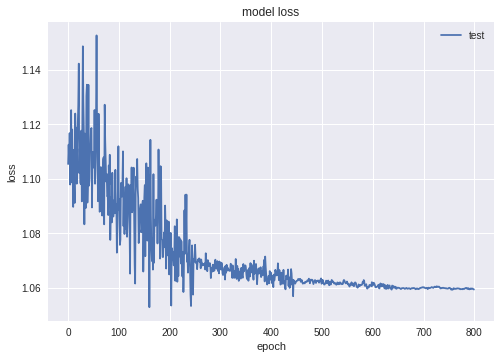

In [235]:
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['test'], loc='upper right');



In [207]:

#Results with full anomily 
full_anom = 0
anom_samples = 1
nb_epoch = 800 # a bit overkill but wanted to see how it progressed w more epochs 
batch_size = 32
import keras
autoencoder.compile(optimizer='nadam', 
                    loss='mean_squared_error', 
                    #loss='kullback_leibler_divergence',
                    metrics=['accuracy'])
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='acc', factor=0.2,min_lr=1e-7,min_delta=0.001,
                              patience=200,verbose = 1)

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(x_train2, x_train2,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    validation_data=(x_test2, x_test2),
                    #validation_split=.1,
                    shuffle=True,
                    verbose=1,callbacks=[reduce_lr, checkpointer, tensorboard]).history 
                         

score = autoencoder.evaluate(x_test2, x_test2, batch_size=32, verbose=1, sample_weight=None, steps=None)

display('[test_loss, test_acc]')
display(score)

Train on 300 samples, validate on 307 samples
Epoch 1/800
300/300 [==============================] - 1s 3ms/step - loss: 0.1205 - acc: 0.8967 - val_loss: 3.0520 - val_acc: 0.0000e+00
Epoch 2/800
300/300 [==============================] - 0s 417us/step - loss: 0.1184 - acc: 0.9233 - val_loss: 3.0335 - val_acc: 0.0000e+00
Epoch 3/800
300/300 [==============================] - 0s 360us/step - loss: 0.1196 - acc: 0.9200 - val_loss: 2.9312 - val_acc: 0.0000e+00
Epoch 4/800
300/300 [==============================] - 0s 355us/step - loss: 0.1199 - acc: 0.8967 - val_loss: 3.0575 - val_acc: 0.0000e+00
Epoch 5/800
300/300 [==============================] - 0s 356us/step - loss: 0.1188 - acc: 0.9267 - val_loss: 3.0571 - val_acc: 0.0000e+00
Epoch 6/800
300/300 [==============================] - 0s 365us/step - loss: 0.1200 - acc: 0.9133 - val_loss: 3.0526 - val_acc: 0.0000e+00
Epoch 7/800
300/300 [==============================] - 0s 370us/step - loss: 0.1184 - acc: 0.9267 - val_loss: 3.0729 - val

KeyboardInterrupt: ignored

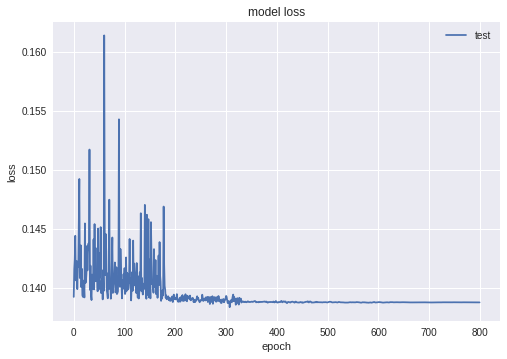

In [222]:
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['test'], loc='upper right');



In [189]:
x_test[0:85,:].astype('int')

array([[  61,   67,   41, 3785, 7435, 9962],
       [  61,   67,   41, 3785, 7435, 9962],
       [  61,   67,   41, 3785, 7435, 9962],
       [  61,   67,   41, 3785, 7435, 9962],
       [  61,   67,   41, 3785, 7435, 9962],
       [  61,   67,   41, 3785, 7435, 9962],
       [  61,   67,   41, 3785, 7435, 9962],
       [  61,   67,   41, 3785, 7435, 9962],
       [  61,   67,   41, 3785, 7435, 9962],
       [  61,   67,   41, 3785, 7435, 9962],
       [  61,   67,   41, 3785, 7435, 9962],
       [  61,   67,   41, 3785, 7435, 9962],
       [  61,   67,   41, 3785, 7435, 9962],
       [  61,   67,   41, 3785, 7435, 9962],
       [  61,   67,   41, 3785, 7435, 9962],
       [  61,   67,   41, 3785, 7435, 9962],
       [  61,   67,   41, 3785, 7435, 9962],
       [  61,   67,   41, 3785, 7435, 9962],
       [  61,   67,   41, 3785, 7435, 9962],
       [  61,    0,   67, 3785, 8740, 7435],
       [  61,   67,   41, 3785, 7435, 9962],
       [  61,   67,   41, 3785, 7435, 9962],
       [  

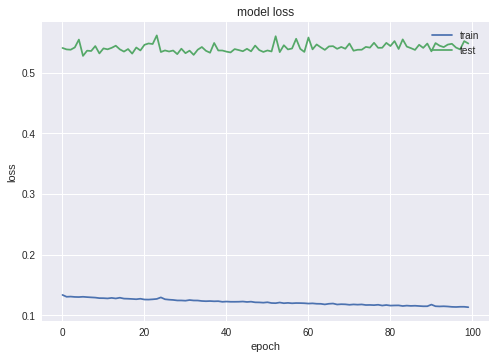

In [163]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');



In [46]:

#Results with full anomily 
full_anom = 1 
anom_samples = 0
nb_epoch = 800 # a bit overkill but wanted to see how it progressed w more epochs 
batch_size = 32
import keras
autoencoder.compile(optimizer='nadam', 
                    loss='mean_squared_error', 
                    #loss='kullback_leibler_divergence',
                    metrics=['accuracy'])
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_acc', factor=0.2,
                              patience=300,verbose = 1)
history = autoencoder.fit(x_train2, x_train2,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    #validation_data=(x_test2[0:200,:], x_test2[0:200,:]),
                    validation_split=.1,
                    verbose=1,callbacks=[reduce_lr])

score = autoencoder.evaluate(x_test2, x_test2, batch_size=32, verbose=1, sample_weight=None, steps=None)

display('[test_loss, test_acc]')
display(score)

Train on 180 samples, validate on 20 samples
Epoch 1/800
180/180 [==============================] - 1s 4ms/step - loss: 0.1152 - acc: 0.8667 - val_loss: 0.1742 - val_acc: 0.7000
Epoch 2/800
180/180 [==============================] - 0s 280us/step - loss: 0.1145 - acc: 0.8611 - val_loss: 0.1704 - val_acc: 0.7500
Epoch 3/800
180/180 [==============================] - 0s 265us/step - loss: 0.1134 - acc: 0.8667 - val_loss: 0.1692 - val_acc: 0.8000
Epoch 4/800
180/180 [==============================] - 0s 276us/step - loss: 0.1138 - acc: 0.8611 - val_loss: 0.1701 - val_acc: 0.7000
Epoch 5/800
180/180 [==============================] - 0s 281us/step - loss: 0.1147 - acc: 0.8556 - val_loss: 0.1743 - val_acc: 0.7500
Epoch 6/800
180/180 [==============================] - 0s 267us/step - loss: 0.1144 - acc: 0.8556 - val_loss: 0.1706 - val_acc: 0.7500
Epoch 7/800
180/180 [==============================] - 0s 281us/step - loss: 0.1145 - acc: 0.8556 - val_loss: 0.1695 - val_acc: 0.8000
Epoch 8/800


'[test_loss, test_acc]'

[28.785220642089843, 0.215]

In [121]:

#Results with full anomily 
full_anom = 1 
anom_samples = 0
nb_epoch = 800 # a bit overkill but wanted to see how it progressed w more epochs 
batch_size = 32
import keras
autoencoder.compile(optimizer='nadam', 
                    loss='mean_squared_error', 
                    #loss='kullback_leibler_divergence',
                    metrics=['accuracy'])
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_acc', factor=0.2,
                              patience=200,verbose = 1)
history = autoencoder.fit(x_train2, x_train2,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    #validation_data=(x_test2[0:200,:], x_test2[0:200,:]),
                    validation_split=.1,
                    verbose=1,callbacks=[reduce_lr])

score = autoencoder.predict( x_test2, batch_size=32, verbose=1, steps=None)

display('[test_loss, test_acc]')
display(score)

Train on 180 samples, validate on 20 samples
Epoch 1/800
180/180 [==============================] - 2s 9ms/step - loss: 0.1203 - acc: 0.8389 - val_loss: 0.0505 - val_acc: 0.9000
Epoch 2/800
180/180 [==============================] - 0s 347us/step - loss: 0.1150 - acc: 0.8722 - val_loss: 0.0492 - val_acc: 0.8500
Epoch 3/800
180/180 [==============================] - 0s 277us/step - loss: 0.1154 - acc: 0.8944 - val_loss: 0.0508 - val_acc: 0.8500
Epoch 4/800
180/180 [==============================] - 0s 286us/step - loss: 0.1158 - acc: 0.8778 - val_loss: 0.0509 - val_acc: 0.8500
Epoch 5/800
180/180 [==============================] - 0s 304us/step - loss: 0.1155 - acc: 0.8778 - val_loss: 0.0510 - val_acc: 0.8000
Epoch 6/800
180/180 [==============================] - 0s 285us/step - loss: 0.1156 - acc: 0.8889 - val_loss: 0.0494 - val_acc: 0.9000
Epoch 7/800
180/180 [==============================] - 0s 277us/step - loss: 0.1157 - acc: 0.8833 - val_loss: 0.0509 - val_acc: 0.9000
Epoch 8/800


'[test_loss, test_acc]'

array([[-0.23071837, -0.03977853, -0.30753464, -0.23373485, -0.2245971 ,
         0.0804491 ],
       [ 1.2501553 ,  0.1461766 ,  2.3173544 ,  1.25168   , -0.31123096,
        -0.9387397 ],
       [ 0.38003436, -0.8984928 ,  1.0986574 ,  0.3778442 ,  1.9418195 ,
        -0.77557313],
       ...,
       [-0.34294498,  0.00456637,  1.2267983 , -0.34612447, -0.24486047,
        -0.80579376],
       [ 0.03626356, -0.01529723, -0.7169802 ,  0.03368816, -0.24747998,
         1.0480211 ],
       [-0.97515094,  1.1910412 , -0.922286  , -0.97556263, -0.78397596,
         2.395676  ]], dtype=float32)

In [122]:
score2 = autoencoder.evaluate(x_test2, x_test2, batch_size=32, verbose=1, sample_weight=None, steps=None)

display('[test_loss, test_acc]')
display(score2)

200/200 [==============================] - 0s 139us/step


'[test_loss, test_acc]'

[0.8472060966491699, 0.57]

In [123]:
display(x_train[3,:])
display(x_train[0,:])
display(x_train[5,:])



array([8.53335151e+01, 7.88288937e+01, 7.13779116e+00, 9.84570089e+03,
       6.51875228e+03, 5.53952782e+03])

array([8.53335430e+01, 7.88288506e+01, 7.13932366e+00, 9.84570282e+03,
       6.51875732e+03, 5.53950301e+03])

array([8.53335452e+01, 7.88288630e+01, 7.13976024e+00, 9.84570297e+03,
       6.51875588e+03, 5.53949594e+03])

In [92]:
display(score[0,:])
display(x_test2[0,:])
display(x_train2[2,:])
display(x_train[3,:])
display(x_test[0,:])

array([-0.2799706 ,  0.7340043 , -0.57149446,  0.20620513,  0.7250215 ,
        0.545471  ], dtype=float32)

array([-0.13627917,  0.71676571, -0.56267982,  0.3875516 ,  0.71680732,
        0.574813  ])

array([-0.18443958,  1.23373152, -1.62555058,  0.42156024,  1.3637031 ,
        1.601184  ])

array([7.98813047e+01, 6.53505302e+01, 1.27098814e+00, 9.01627079e+03,
       4.86375687e+03, 2.22070061e+03])

array([7.98813043e+01, 3.41690118e-01, 1.26727822e+00, 9.01627280e+03,
       3.80362979e+02, 2.22112900e+03])

In [0]:
#Results with one sample anomily 
# the duration of the anom can be tuned with anom_samples
full_anom = 0
anom_samples = 1
nb_epoch = 800 # a bit overkill but wanted to see how it progressed w more epochs 
batch_size = 32
import keras
autoencoder.compile(optimizer='nadam', 
                    loss='mean_squared_error', 
                    #loss='kullback_leibler_divergence',
                    metrics=['accuracy'])
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_acc', factor=0.2,
                              patience=300,verbose = 1)
history = autoencoder.fit(x_train2, x_train2,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    #validation_data=(x_test2[0:200,:], x_test2[0:200,:]),
                    validation_split=.1,
                    verbose=1,callbacks=[reduce_lr])

score = autoencoder.evaluate(x_test2, x_test2, batch_size=32, verbose=1, sample_weight=None, steps=None)

display('[test_loss, test_acc]')
display(score)

Train on 180 samples, validate on 20 samples
Epoch 1/800
180/180 [==============================] - 9s 48ms/step - loss: 1.5007 - acc: 0.1944 - val_loss: 1.4750 - val_acc: 0.0500
Epoch 2/800
180/180 [==============================] - 0s 353us/step - loss: 1.4188 - acc: 0.1778 - val_loss: 1.3748 - val_acc: 0.1000
Epoch 3/800
180/180 [==============================] - 0s 345us/step - loss: 1.3436 - acc: 0.1778 - val_loss: 1.2763 - val_acc: 0.1000
Epoch 4/800
180/180 [==============================] - 0s 350us/step - loss: 1.2729 - acc: 0.1889 - val_loss: 1.1892 - val_acc: 0.1000
Epoch 5/800
180/180 [==============================] - 0s 372us/step - loss: 1.2061 - acc: 0.2000 - val_loss: 1.1073 - val_acc: 0.0500
Epoch 6/800
180/180 [==============================] - 0s 348us/step - loss: 1.1525 - acc: 0.2222 - val_loss: 1.0312 - val_acc: 0.0500
Epoch 7/800
180/180 [==============================] - 0s 366us/step - loss: 1.0978 - acc: 0.2389 - val_loss: 0.9676 - val_acc: 0.0500
Epoch 8/800

'[test_loss, test_acc]'

[5.602794224875314, 0.276190476332392]